**Chapter 7, end-of-chapter problems**


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.interpolate import griddata

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(vec):
    return (vec - np.mean(vec)) / np.std(vec)

<IPython.core.display.Javascript object>

# 7E1

State the three motivating criteria that define information entropy. Try to express each in your own words.


1. Something that can be on a continuous scale. "Measure of uncertainty should be continuous."
2. Something that accounts for the number of events. "Measure of uncertainty should increase as number of possible events increases." (More ways to be wrong.)
3. "Measure of uncertainty should be additive." (The uncertainty over all combinations of events should be additive of the separate uncertainties.)

This can be seen in the equation:
$E =  - \displaystyle\sum\limits_{i=1}^{n} p_i\log{p_i}$


# 7E2

Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads 70% of the time. What is the entropy of this coin?

Taking the equation of entropy, there's two possible events: heads and tails. The probability of heads is 0.7 and the probability of tails is 0.3.

In [7]:
coin = [0.7, 0.3]
entropy = 0

for i in coin:
    entropy += i * np.log(i)
    
print(-entropy)

0.6108643020548935


<IPython.core.display.Javascript object>

**Why can't we just take one? Wouldn't it be deterministic for the other? Correct thing is to use both.**

# 7E3.

Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, “3” 25%, and “4” 30% of the time. What is the entropy of this die?

In [10]:
die = [0.2, 0.25, 0.25, 0.3]
entropy = 0

for side in die:
    entropy += i * np.log(i)
    
print(-entropy)


1.4447673651911233


<IPython.core.display.Javascript object>

# 7E4

Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die?

In [11]:
die = [0, 0.33, 0.33, 0.33]
entropy = 0

for side in die:
    entropy += i * np.log(i)
    
print(-entropy)


1.4447673651911233


<IPython.core.display.Javascript object>

# 7M3.

When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments, if you are not sure.

The calculation of lppd depends on the number of observations and if model comparison is done, it is imperative to use exactly the same observations.

Sample size matters also will determine the degree to which regularization matters. When there are more samples, the priors matter less and different IC (PSIS and WAIC) will tend to agree.

This can be seen directly in the lppd equation itself.

$$lppd = \sum_i log\frac{1}{S}\sum_s p(y_i| \Theta_s)  $$



Inside the log, is the mean conditional probabilities for one data point averaging over the posterior distribution of parameters.

# 7M4. 

What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior becomes more concentrated? Why? Perform some experiments, if you are not sure.

As I'm thinking about this, I know that the "right" answer should be that the effective number of parameters decreases as the prior gets more concentrated. By making the prior more concentrated (or regularizing), you're limiting the degree to which the model will overfit, thereby making the out-of-sample deviance smaller. The whole point of information criterion is that it is an estimate of out-of-sample deviance. With more (effective) parameters the out-of-sample deviance can get larger.

You can see this reflected in the equation fo WAIC and the penalty term (penalty term being the effective number of parameters, which is the summation term).

$$\text{WAIC}(y, \Theta) = −2(\text{lppd} −\sum_i\text{var}_\theta\text{log}p(y_i|\theta))$$

It's not clear to me what the exact equation for PSIS is but the principle is the same as far as I can tell.

Let's use the primate dataset to show how changing the prior can affect the effective number of parameters.

## Setting up the problem

In [24]:
# code modified from the repo

df_brains = pd.DataFrame(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

<IPython.core.display.Javascript object>

In [25]:
# Standardized
df_brains["mass_std"] = standardize(df_brains["mass"])  

# Standardize variables (min-max scale)
df_brains["brain_std"] = (
    df_brains["brain"] / df_brains["brain"].max()
)  # min-max scaling (min at 0)


<IPython.core.display.Javascript object>

In [26]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'standardized values')

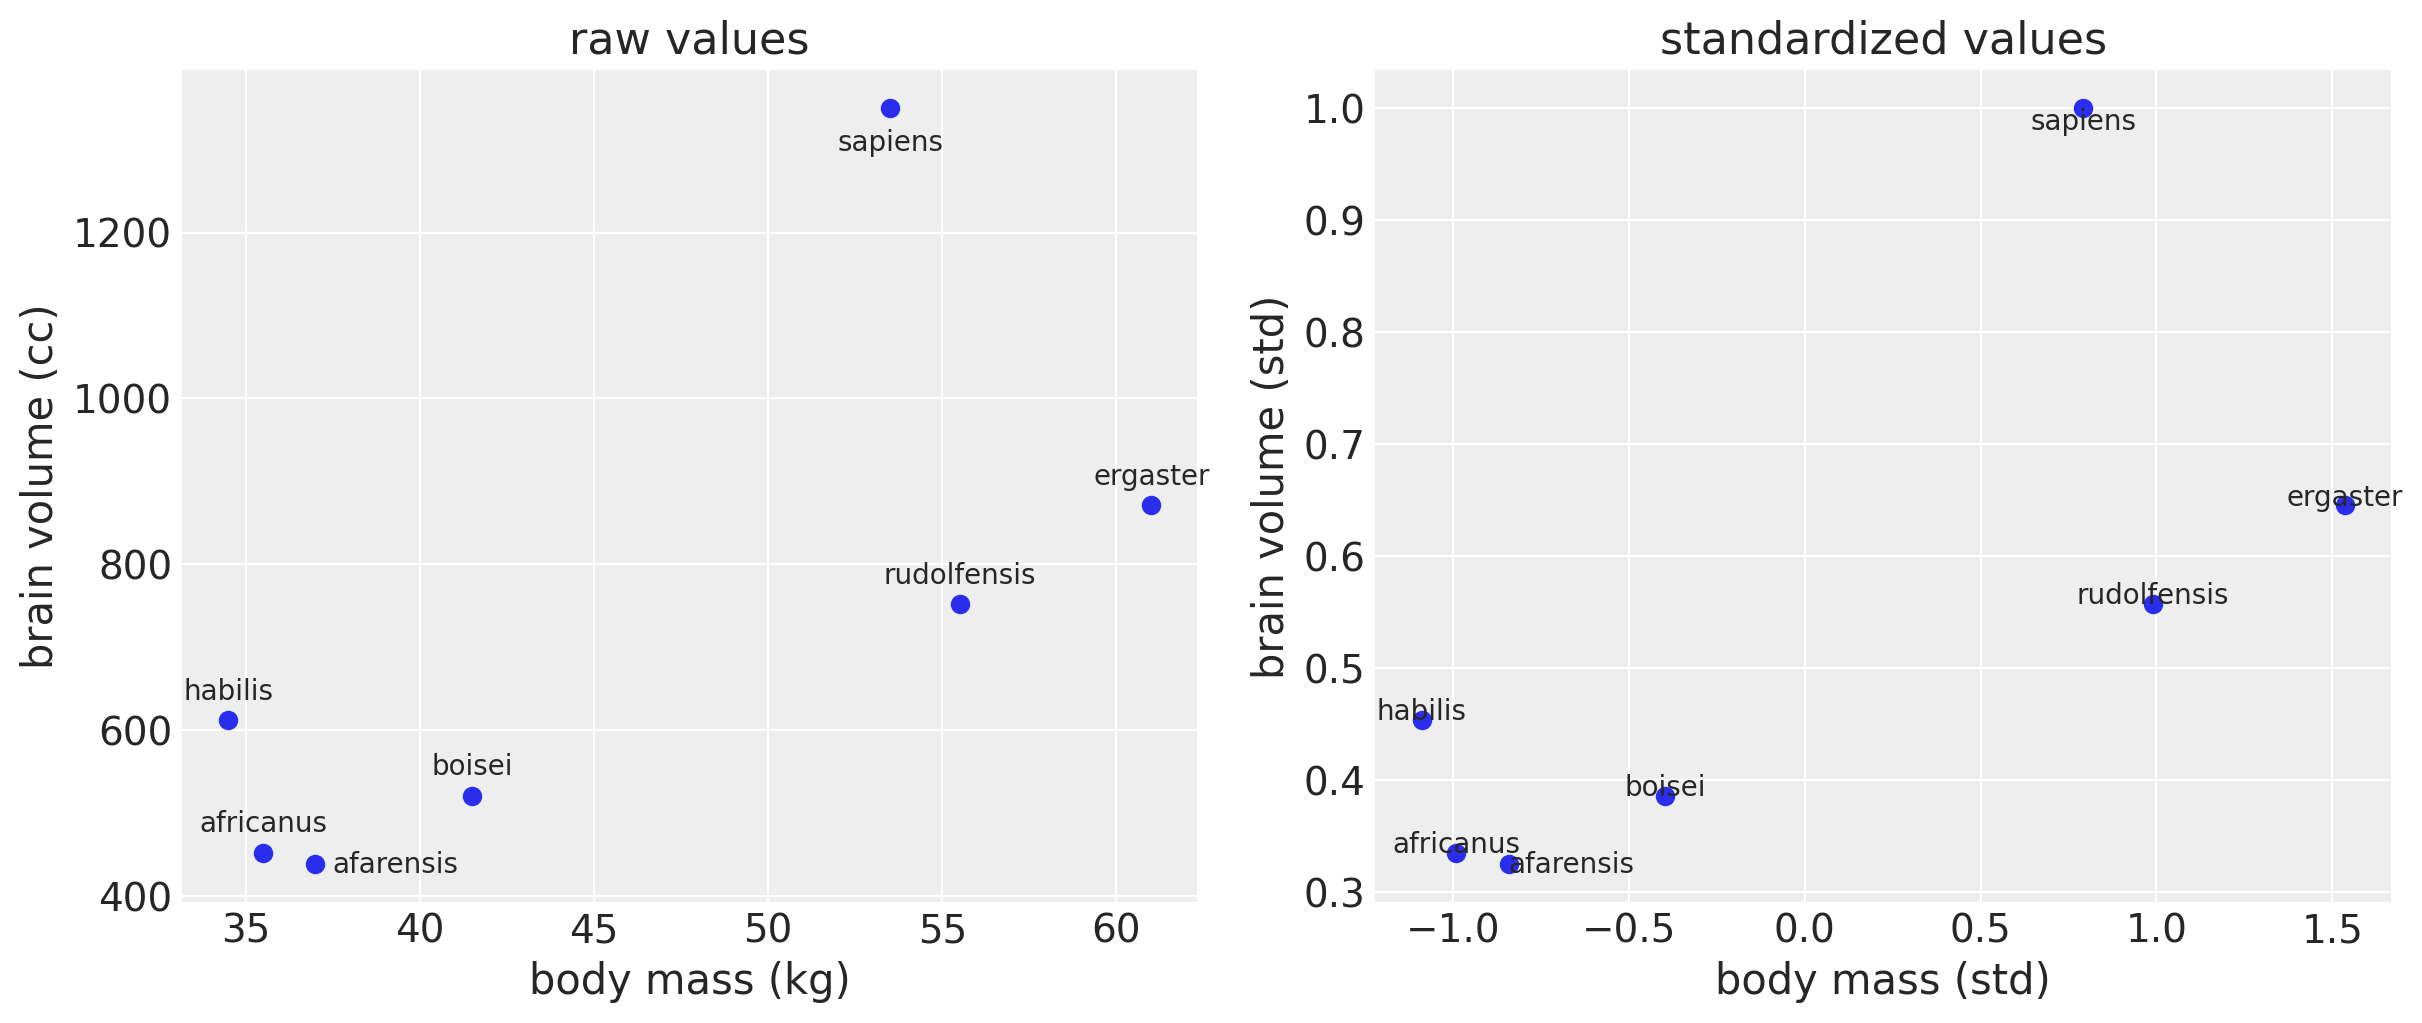

<IPython.core.display.Javascript object>

In [27]:
# Figure 7.2, modified from repo

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(df_brains["mass"], df_brains["brain"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax1.text(r["mass"] + 0.5, r["brain"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax1.text(r["mass"], r["brain"] - 25, r["species"], ha="center", va="top")
    else:
        ax1.text(r["mass"], r["brain"] + 25, r["species"], ha="center")

ax1.set_xlabel("body mass (kg)")
ax1.set_ylabel("brain volume (cc)")
ax1.set_title("raw values")

ax2.scatter(df_brains["mass_std"], df_brains["brain_std"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center", va="top")
    else:
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center")

ax2.set_xlabel("body mass (std)")
ax2.set_ylabel("brain volume (std)")
ax2.set_title("standardized values")

## 1 parameter, three different models with different SD for the beta coefficients

In [9]:
with pm.Model() as m7_1_sd10:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=10)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = a + b * df_brains["mass_std"]
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace_sd10 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

In [10]:
with pm.Model() as m7_1_sd5:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=5)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = a + b * df_brains["mass_std"]
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace_sd5 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


<IPython.core.display.Javascript object>

In [11]:
with pm.Model() as m7_1_sd1:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=1)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = a + b * df_brains["mass_std"]
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace_sd1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


<IPython.core.display.Javascript object>

In [59]:
az.summary(trace_sd10)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.526,0.121,0.372,0.708,0.003,0.002,1509.0,1356.0,1919.0,1264.0,1.0
b,0.158,0.114,0.002,0.329,0.003,0.003,1941.0,1012.0,2473.0,1468.0,1.0
log_sigma,-1.385,0.397,-2.004,-0.789,0.013,0.009,956.0,956.0,1032.0,1094.0,1.0


<IPython.core.display.Javascript object>

In [60]:
az.summary(trace_sd5)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.528,0.119,0.349,0.693,0.003,0.002,2122.0,1784.0,2389.0,1224.0,1.0
b,0.149,0.124,-0.014,0.317,0.003,0.003,1474.0,920.0,1829.0,1336.0,1.0
log_sigma,-1.392,0.386,-2.030,-0.858,0.011,0.008,1133.0,1133.0,1207.0,1416.0,1.0


<IPython.core.display.Javascript object>

In [61]:
az.summary(trace_sd1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.527,0.114,0.369,0.695,0.003,0.002,1745.0,1322.0,2244.0,1586.0,1.00
b,0.151,0.111,-0.010,0.320,0.003,0.002,1894.0,1664.0,2124.0,1586.0,1.01
log_sigma,-1.387,0.385,-2.032,-0.841,0.010,0.007,1376.0,1376.0,1446.0,1702.0,1.00


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'log_sigma'}>,
        <AxesSubplot:title={'center':'log_sigma'}>]], dtype=object)

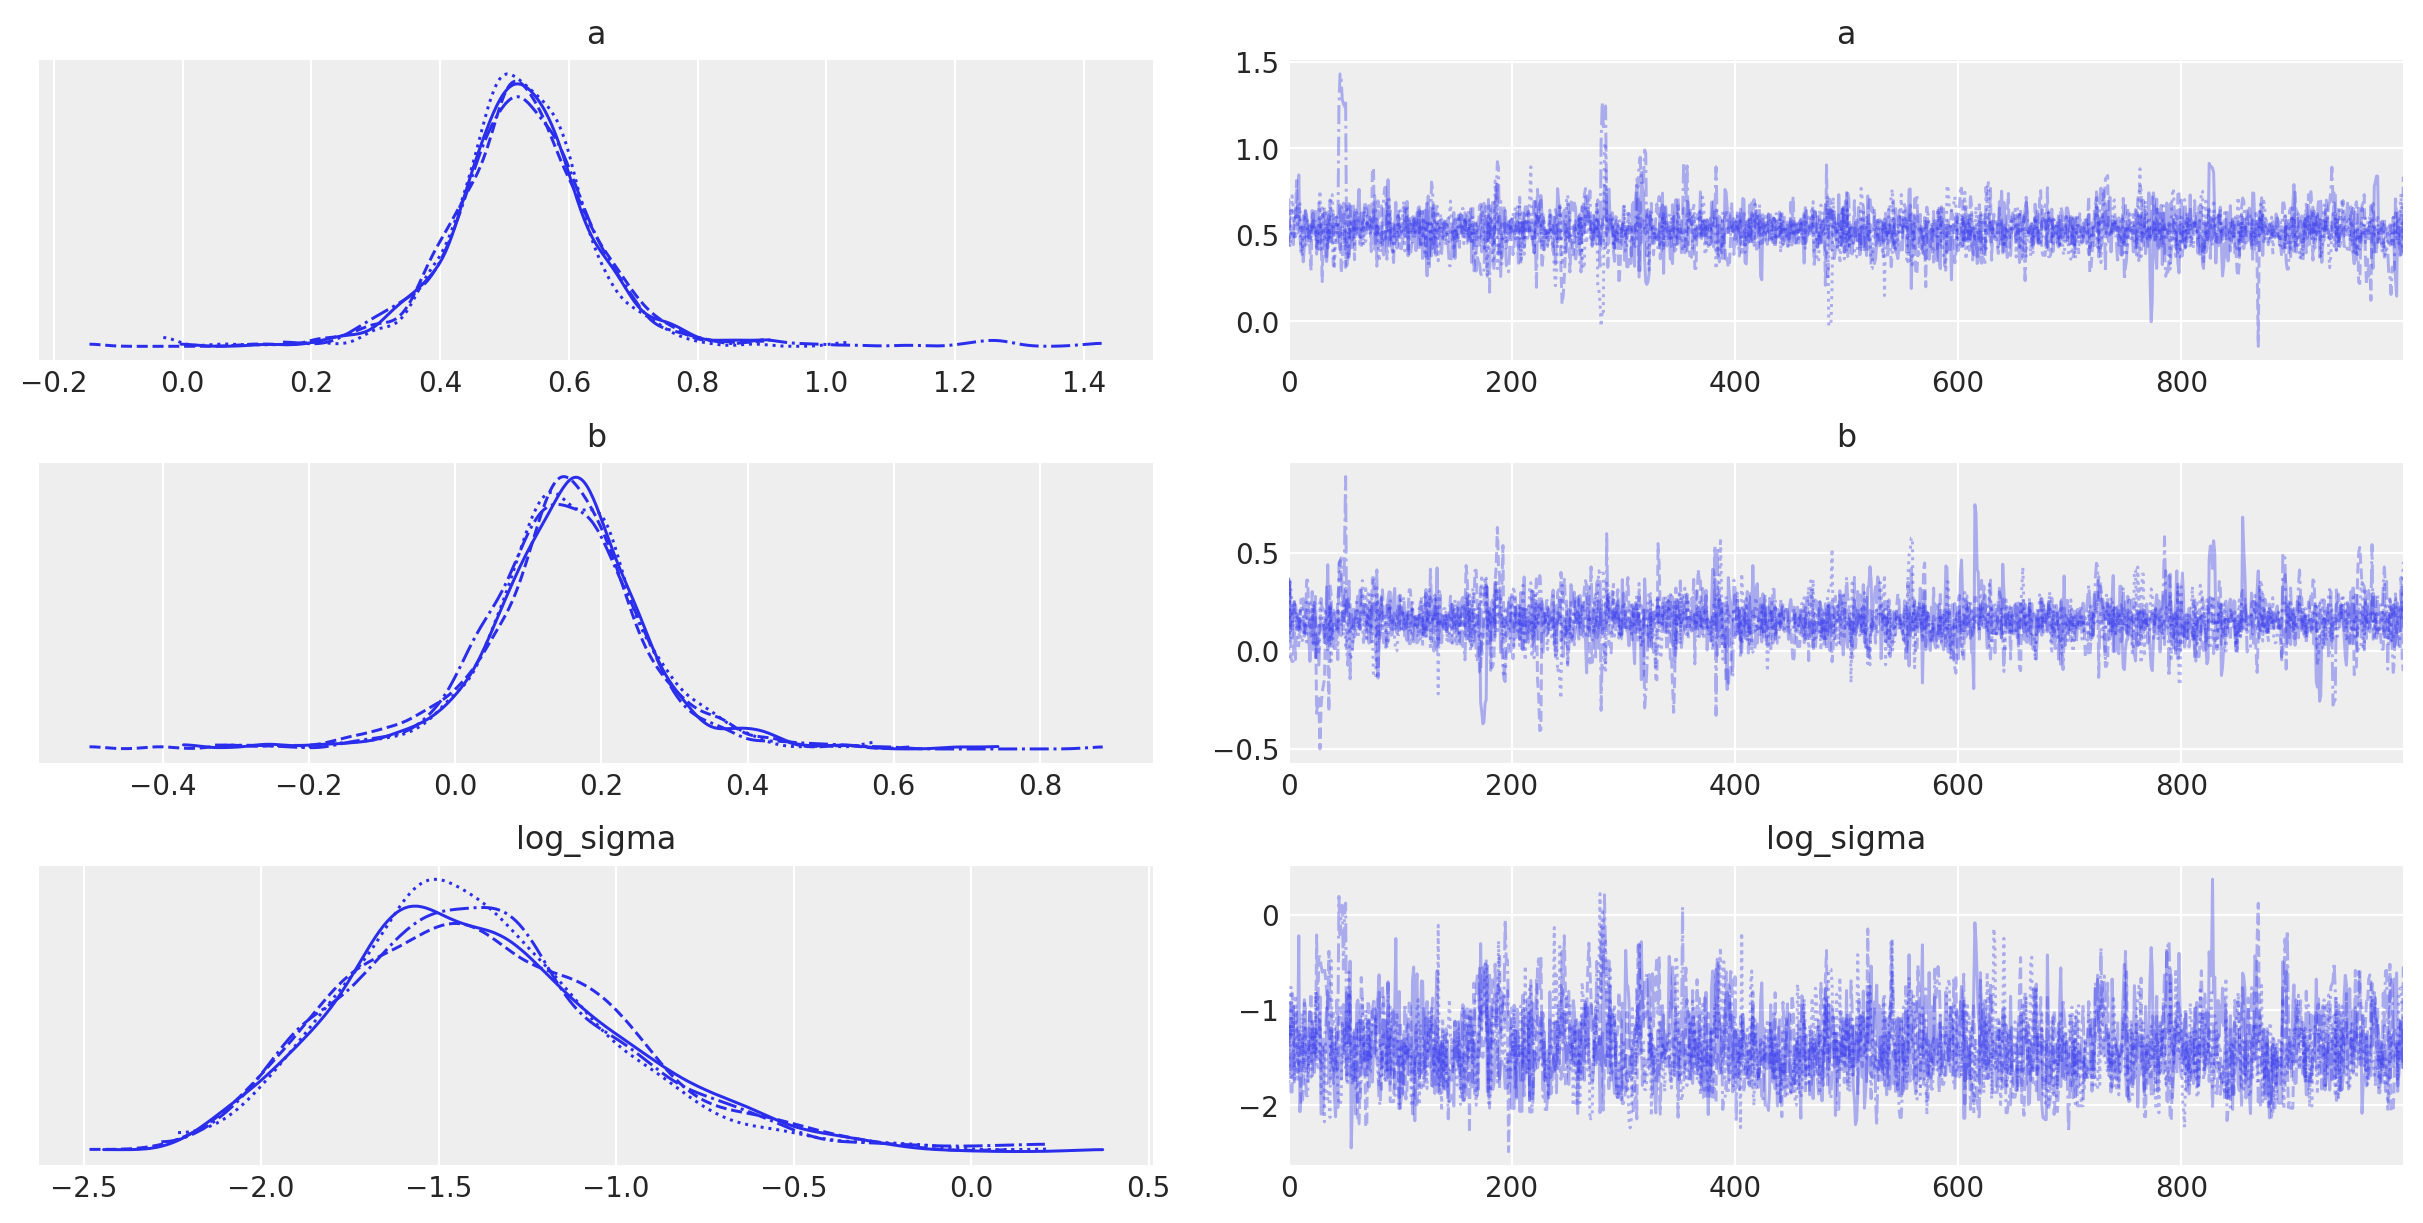

<IPython.core.display.Javascript object>

In [69]:
az.plot_trace(trace_sd1)

### Look at predictive density

In [34]:
def get_predictions(trace):

    trace_df = trace.to_dataframe()

    # Input a range of x-axis (standardized body mass) values
    bm_seq = np.arange(-1.5, 2, 0.2)

    # This is generating a matrix where the predicted standardized brain volume
    # values will be kept. Each body mass value will be its own row.
    vol_pred = np.zeros((len(bm_seq), len(trace_df)))

    # Fill out the matrix in this loop
    for i, bm in enumerate(bm_seq):
        vol_pred[i] = stats.norm.rvs(
            loc=trace_df[("posterior", "a")] + trace_df[("posterior", "b")] * bm,
            scale=np.exp(trace_df[("posterior", "a")]),
        )

    # Output the matrix in a dataframe for viewing
    df_vol_pred = pd.DataFrame(vol_pred, index=bm_seq)
    df_vol_pred.index.name = "bm"
    return df_vol_pred

<IPython.core.display.Javascript object>

In [37]:
df_vol_pred_sd10 = get_predictions(trace_sd10)
df_vol_pred_sd5 = get_predictions(trace_sd5)
df_vol_pred_sd1 = get_predictions(trace_sd1)

<IPython.core.display.Javascript object>

In [43]:
df_vol_pred_sd1.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
bm,,,,,,,,,,,,,,,,,,,,,
-1.5,2.210354,2.896935,4.651365,1.169480,1.208435,-0.371969,2.395048,-0.771231,0.525252,-1.100447,...,2.809844,2.511609,0.970628,-0.292207,-0.481080,0.494935,-0.989664,0.630503,-1.921292,-2.963989
-1.3,4.867597,0.954570,-0.332152,1.741702,-0.301097,0.023473,0.819946,1.160550,2.550466,-0.160955,...,-0.227537,-0.366626,-2.248971,1.142581,1.907777,3.170431,-1.210799,1.426154,-0.960250,1.337597
-1.1,0.727967,1.010043,2.155303,0.162282,-2.720149,0.020868,0.885985,-0.296959,-2.514496,-3.298257,...,-0.110288,0.039167,0.481459,-1.330411,1.673125,1.723645,0.999348,0.984426,1.555935,-1.565991
-0.9,0.124188,-1.346944,1.122310,-2.332478,-1.664448,0.789034,-1.526791,0.131746,1.209964,-5.057425,...,-0.603668,0.207295,0.075648,0.201235,1.337443,1.815875,1.432557,0.804533,-2.317575,-1.778220
-0.7,0.694149,1.993447,1.807531,1.913893,-1.147592,-0.170699,-2.897306,-3.653790,-1.047131,1.117079,...,-1.894350,-1.717218,4.226922,1.408040,3.906964,1.183987,-1.483413,1.493271,-2.782915,-0.639254


<IPython.core.display.Javascript object>

In [54]:
df_vol_pred_sd1.min().min(), df_vol_pred_sd1.max().max()

(-7.942564363093607, 13.741870089466918)

<IPython.core.display.Javascript object>

In [55]:
df_vol_pred_sd10.min().min(), df_vol_pred_sd10.max().max()

(-8.460384640279809, 12.336146309841062)

<IPython.core.display.Javascript object>

In [56]:
df_vol_pred_sd5.min().min(), df_vol_pred_sd5.max().max()

(-10.76339808427701, 14.194108644947697)

<IPython.core.display.Javascript object>

In [45]:
bm_seq = np.arange(-1.5, 2, 0.2)
bm_seq.shape

(18,)

<IPython.core.display.Javascript object>

In [46]:
df_vol_pred_sd1.shape

(18, 4000)

<IPython.core.display.Javascript object>

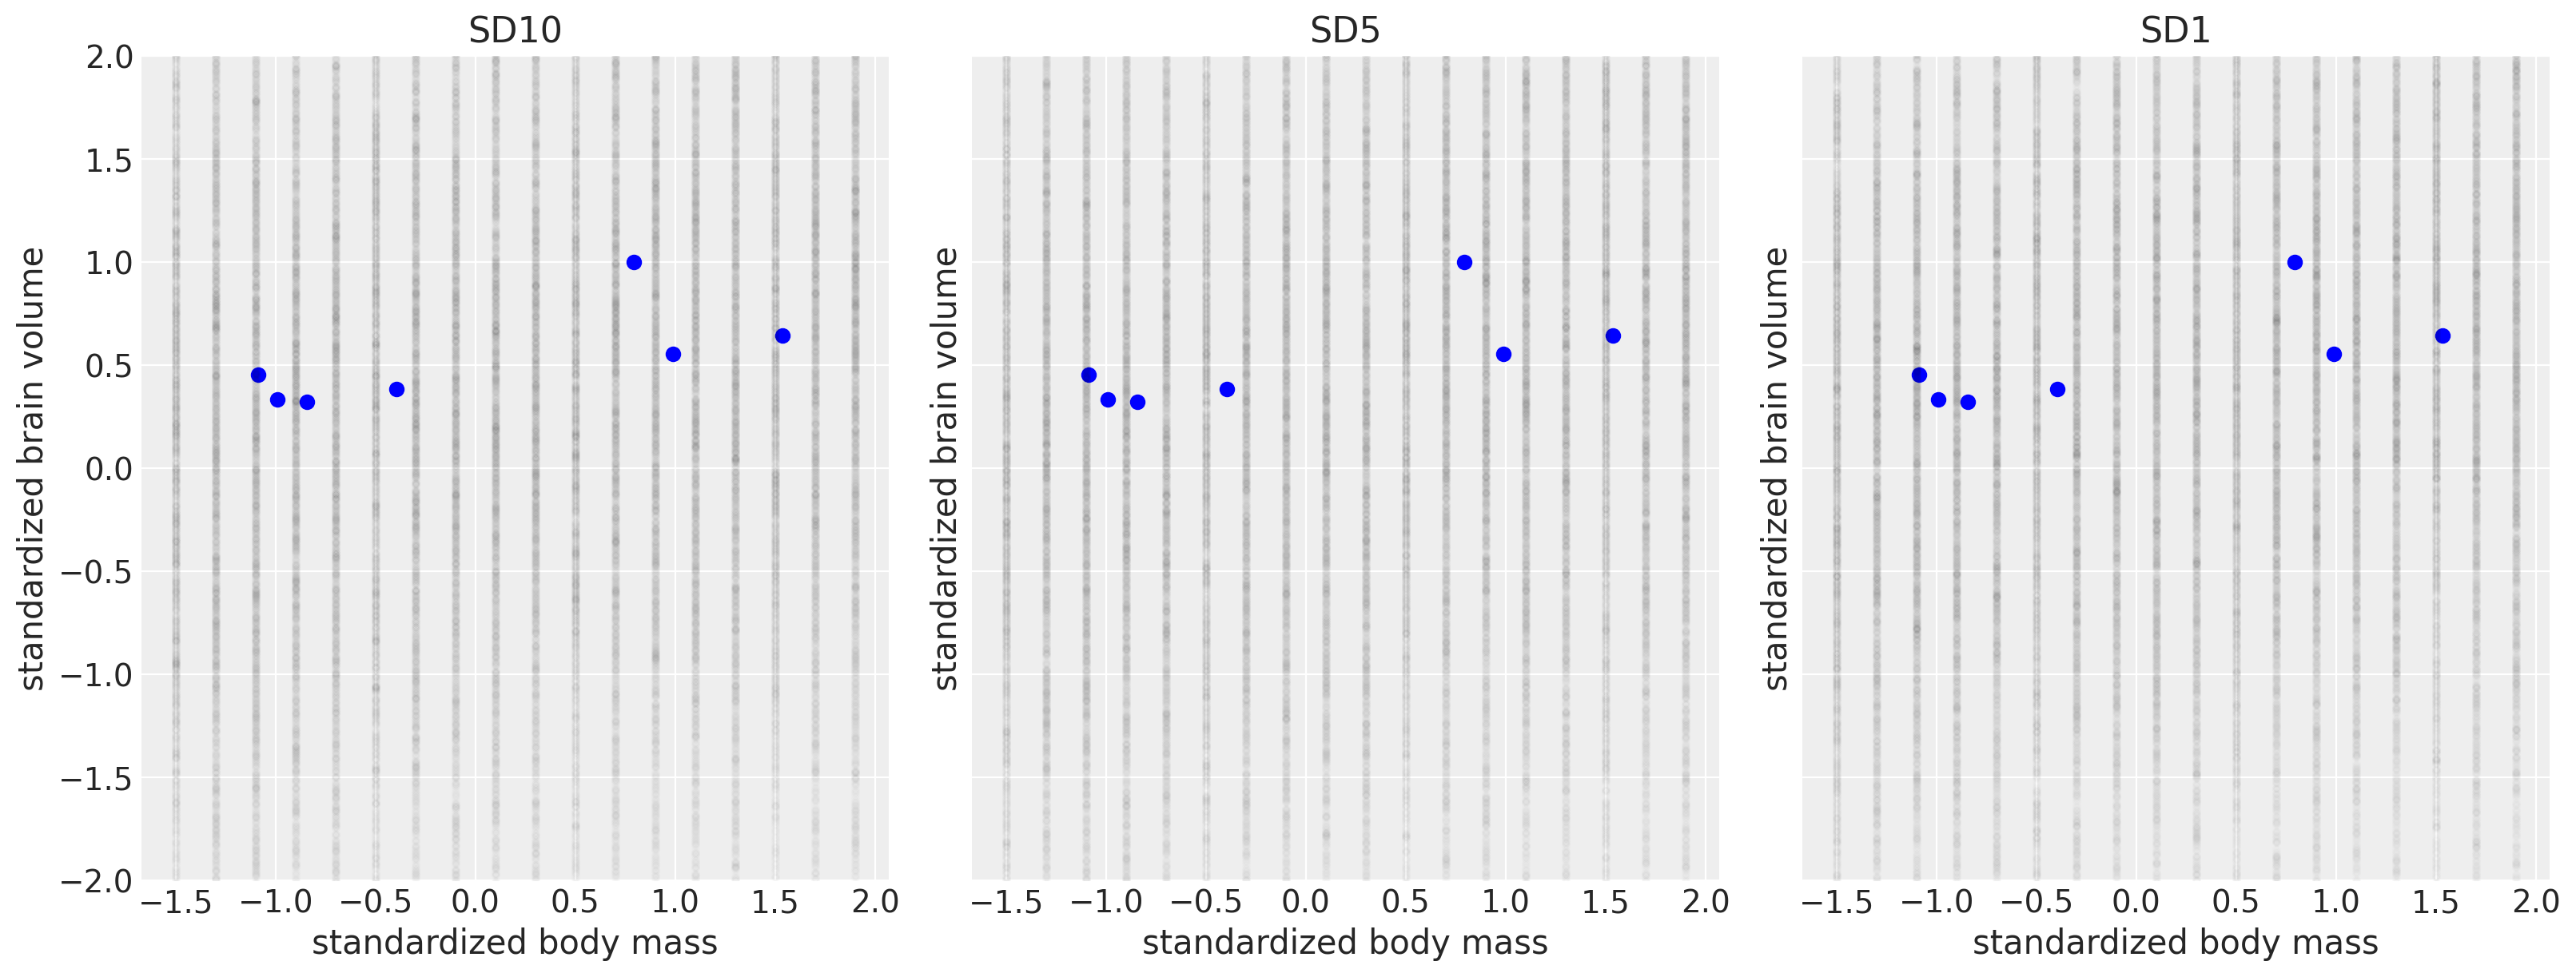

<IPython.core.display.Javascript object>

In [58]:
f, axes = plt.subplots(1, 3, figsize=(16, 6), sharey="row", sharex=True)

traces = [trace_sd10, trace_sd5, trace_sd1]
preds = [df_vol_pred_sd10, df_vol_pred_sd5, df_vol_pred_sd1]
titles = ["SD10", "SD5", "SD1"]

for trace, pred, title, ax in zip(traces, preds, titles, axes.flat):
    # Original data
    ax.scatter(df_brains["mass_std"], df_brains["brain_std"], color="blue")
    ax.set_xlabel("body mass (std)")
    ax.set_ylabel("brain volume (std)")
    ax.set_title("standardized values")

    # Predictions as a scatter plot
    ax.plot(
        bm_seq, np.array(pred), "C0.", color="gray", alpha=0.005
    )  # Using broadcasting to plot
    ax.set_xlabel("standardized body mass")
    ax.set_ylabel("standardized brain volume")
    ax.set_title(title)

    ax.set_ylim(-2, 2)

Text(0.5, 1.0, 'Uncertainty of $h_i$')

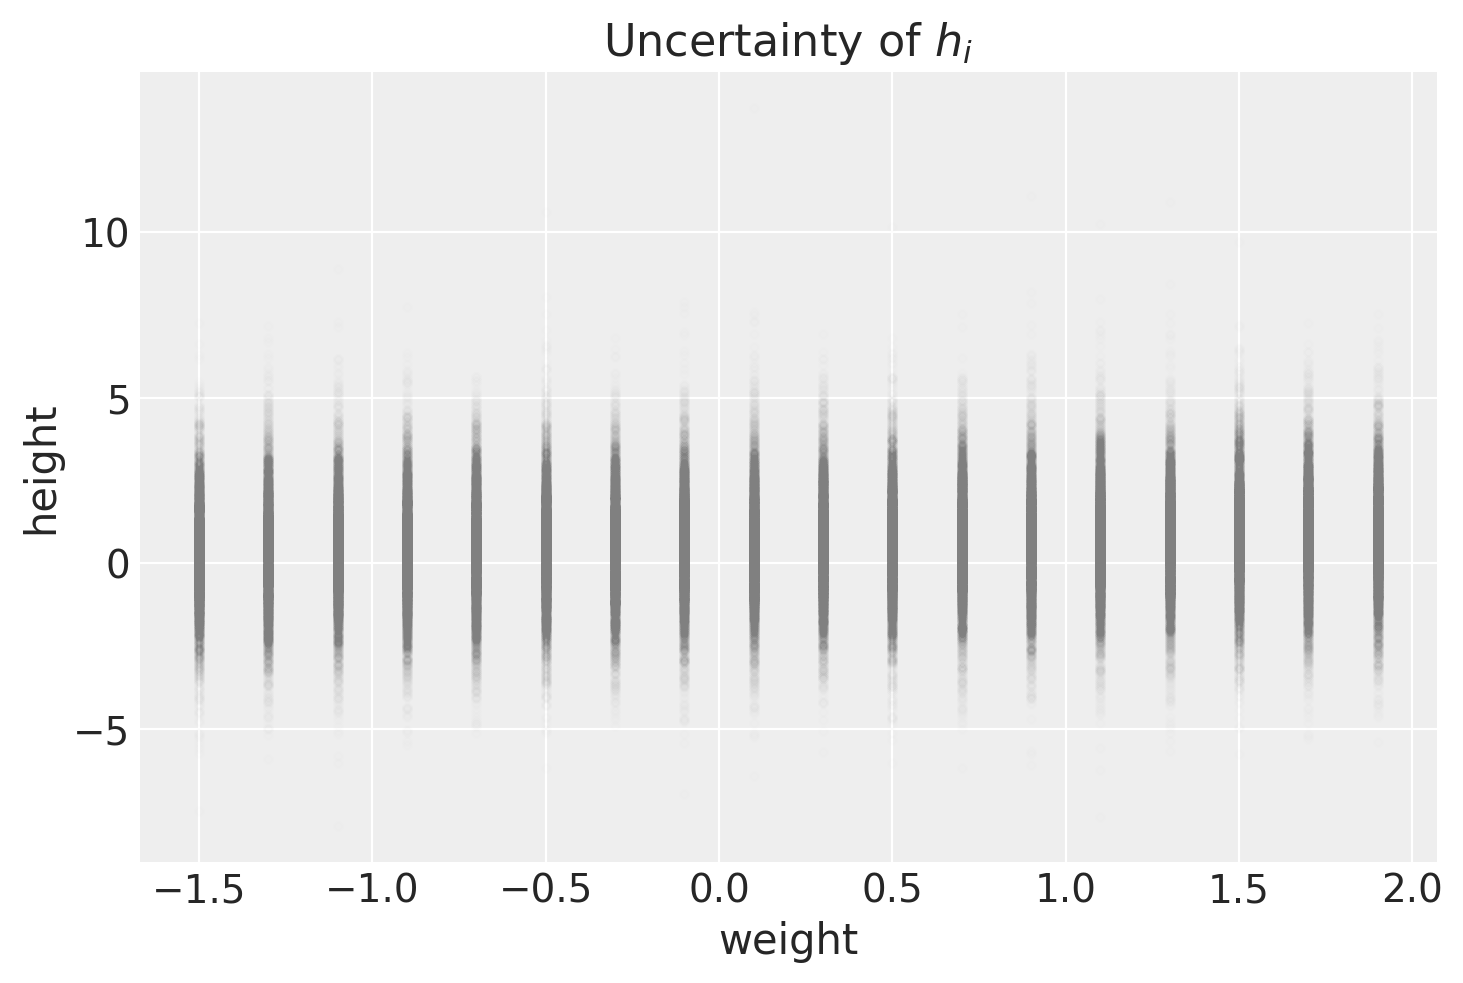

<IPython.core.display.Javascript object>

In [51]:
# Plotting the data as a scatter plot
# plt.scatter(d2["weight"], d2["height"], alpha=0.5)
plt.plot(bm_seq, np.array(df_vol_pred_sd1), "C0.", color="gray", alpha=0.005)
plt.xlabel("weight")
plt.ylabel("height")
plt.title("Uncertainty of $h_i$")

In [38]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

### Number of effective samples

I intended to do number of effective parameters when I got confused and did number of effective samples. nevertheleess, we can look at this.

In [65]:
SDval = ["10", "5", "1"]
ess_means = list()

for i, trace in enumerate([trace_sd10, trace_sd5, trace_sd1]):
    ess_mean = az.summary(trace).loc["b", "ess_mean"]
    print("SD" + SDval[i], ", ess_mean: ", ess_mean)
    ess_means.append(ess_mean)

SD10 , ess_mean:  1941.0
SD5 , ess_mean:  1474.0
SD1 , ess_mean:  1894.0


<IPython.core.display.Javascript object>

Text(0, 0.5, 'ess_mean')

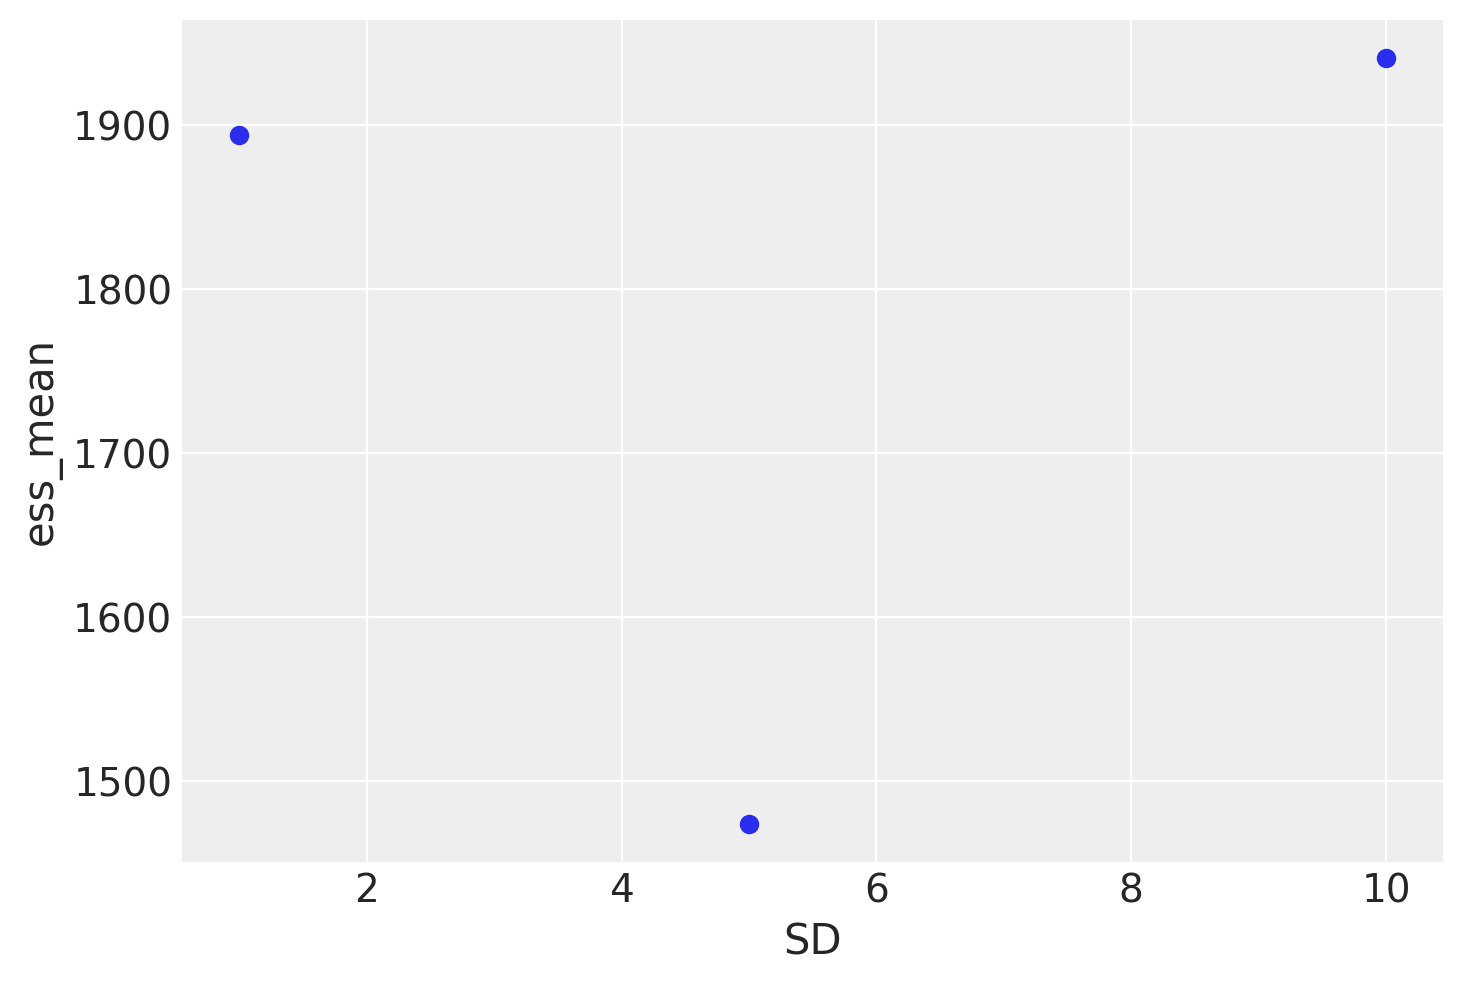

<IPython.core.display.Javascript object>

In [68]:
f, ax1 = plt.subplots()
ax1.scatter([10, 5, 1], ess_means)
ax1.set_xlabel("SD")
ax1.set_ylabel("ess_mean")

Why does it dip at SD of 5??

### IC summary

View PSIS and WAIC values

Note that the documentation ([az.compare](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) and  [az.plot_compare](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_compare.html)) states "loo" for PSIS and "waic" for WAIC.

In [16]:
model_compare_psis_1p = az.compare(
    {"sd10": trace_sd10, "sd5": trace_sd5, "sd1": trace_sd1},
    scale="deviance",
    ic="loo",
)

model_compare_psis_1p

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
sd1,0,2.256540,2.487351,0.000000,1.0,3.567714,0.000000,True,deviance
sd10,1,2.420833,2.544255,0.164294,0.0,3.393477,0.193451,True,deviance
sd5,2,2.544023,2.636926,0.287483,0.0,3.612576,0.077105,True,deviance


<IPython.core.display.Javascript object>

In [75]:
data1 = az.load_arviz_data("non_centered_eight")
data2 = az.load_arviz_data("centered_eight")
compare_dict = {"non centered": data1, "centered": data2}
az.compare(compare_dict)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
non centered,0,-30.687290,0.841888,0.000000,1.0,1.364996,0.000000,False,log
centered,1,-30.810374,0.954053,0.123084,0.0,1.426837,0.086046,False,log


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Deviance'>

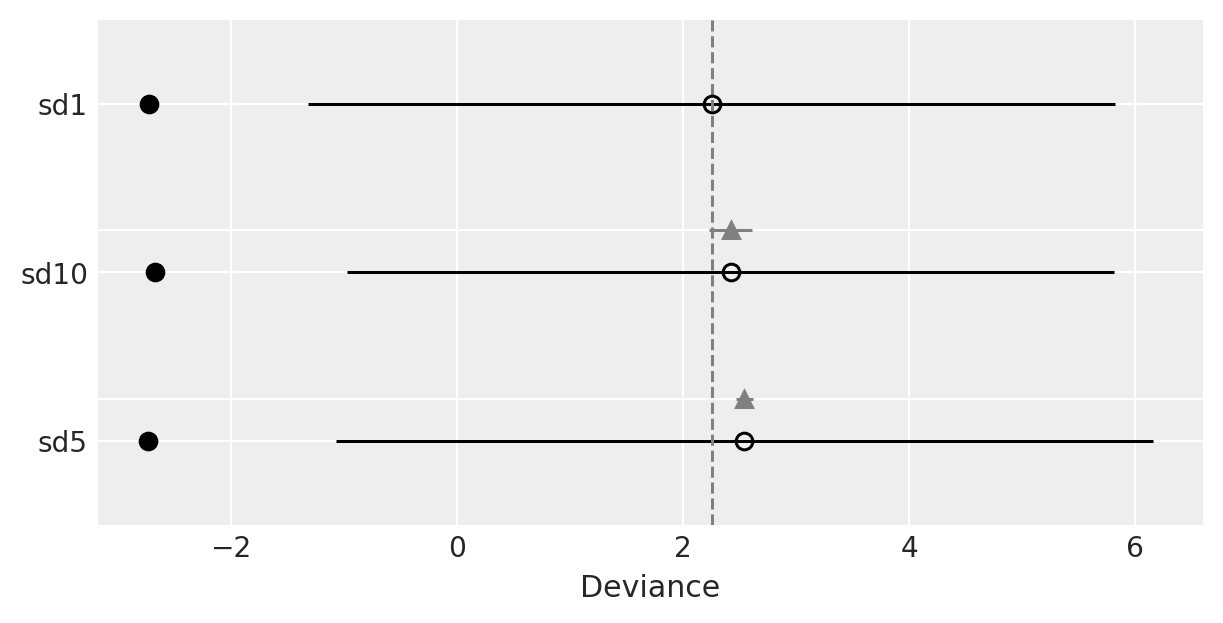

<IPython.core.display.Javascript object>

In [17]:
az.plot_compare(model_compare_psis)

In [18]:
model_compare_waic = az.compare(
    {"sd10": trace_sd10, "sd5": trace_sd5, "sd1": trace_sd1},
    scale="deviance",
    ic="waic",
)

model_compare_waic

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: U

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
sd1,0,1.660108,2.189135,0.000000,1.000000e+00,3.120904,0.000000,True,deviance
sd5,1,1.836412,2.283121,0.176304,0.000000e+00,3.109271,0.053516,True,deviance
sd10,2,1.923165,2.295421,0.263057,6.661338e-16,3.034265,0.117047,True,deviance


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Deviance'>

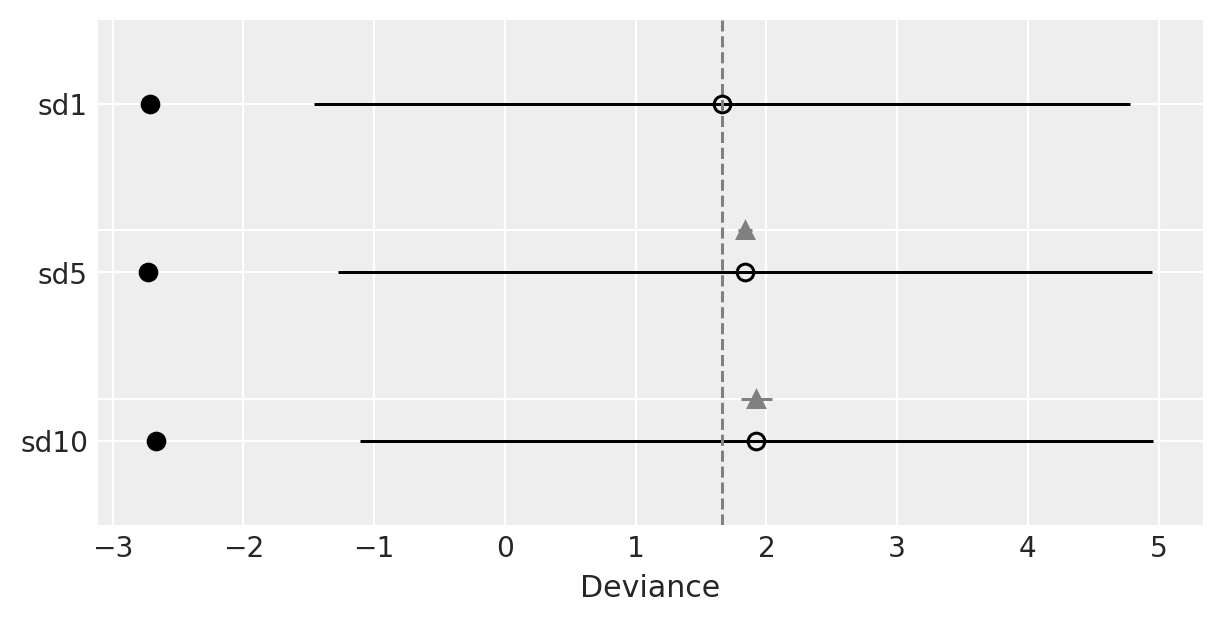

<IPython.core.display.Javascript object>

In [19]:
az.plot_compare(model_compare_waic)

Initially I didn't know where the number of effective parameters was. The [documentation](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) shows this:

`pIC: Estimated effective number of parameters`

**I realized it's `p_loo` and `p_waic` for PSIS and WAIC respectively. We can see that things didn't change much between the different regularizations, but it's because the model is underfit. When it's already fit poorly to the training data, then you're not going to see much difference in information criterion.**

## 3 parameters

In [76]:
with pm.Model() as m7_3_sd10:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = (
        a
        + b[0] * df_brains["mass_std"]
        + b[1] * df_brains["mass_std"] ** 2
        + b[2] * df_brains["mass_std"] ** 3
    )
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace3_sd10 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
INFO:pymc3:NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40062095215144133, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 57 diverg

<IPython.core.display.Javascript object>

In [78]:
with pm.Model() as m7_3_sd5:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=5, shape=3)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = (
        a
        + b[0] * df_brains["mass_std"]
        + b[1] * df_brains["mass_std"] ** 2
        + b[2] * df_brains["mass_std"] ** 3
    )
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace3_sd5 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
INFO:pymc3:NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6096830684310474, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergenc

<IPython.core.display.Javascript object>

In [79]:
with pm.Model() as m7_3_sd1:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=1, shape=3)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = (
        a
        + b[0] * df_brains["mass_std"]
        + b[1] * df_brains["mass_std"] ** 2
        + b[2] * df_brains["mass_std"] ** 3
    )
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace3_sd1 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
INFO:pymc3:NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7094263953022379, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 48 divergenc

<IPython.core.display.Javascript object>

### IC summmary

In [81]:
model_compare_psis = az.compare(
    {"sd10": trace3_sd10, "sd5": trace3_sd5, "sd1": trace3_sd1},
    scale="deviance",
    ic="loo",
)

model_compare_psis

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
sd5,0,5.870768,3.763708,0.000000,1.000000e+00,2.121088,0.000000,True,deviance
sd1,1,6.162166,3.725756,0.291398,0.000000e+00,2.108106,0.451552,True,deviance
sd10,2,6.563466,3.733607,0.692699,9.992007e-16,1.673090,0.537325,True,deviance


<IPython.core.display.Javascript object>

In [83]:
model_compare_waic = az.compare(
    {"sd10": trace3_sd10, "sd5": trace3_sd5, "sd1": trace3_sd1},
    scale="deviance",
    ic="waic",
)

model_compare_waic

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: U

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
sd5,0,4.770301,3.213474,0.000000,1.000000e+00,1.744570,0.000000,True,deviance
sd1,1,4.959627,3.124486,0.189326,0.000000e+00,1.683554,0.315282,True,deviance
sd10,2,5.586898,3.245323,0.816597,1.443290e-15,1.430590,0.419709,True,deviance


<IPython.core.display.Javascript object>

With three parameters, the intermediate regularization is the best. In this scenario, I found a situation where being too skeptical is bad. Per the book:
> If the prior is too skeptical, however, then regular features will be missed, resulting in underfitting. So the problem is really one of tuning.



## 5 parameters

In [29]:
with pm.Model() as m7_5_sd10:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=10, shape=5)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = (
        a
        + b[0] * df_brains["mass_std"]
        + b[1] * df_brains["mass_std"] ** 2
        + b[2] * df_brains["mass_std"] ** 3
        + b[3] * df_brains["mass_std"] ** 4
        + b[4] * df_brains["mass_std"] ** 5
    )
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace5_sd10 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7078312428564595, but should be close to 0.8. Try to increase the number of tuning steps.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7142104160354575, but should be close to 0.8. Try to increase the number of tuning steps.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is small

<IPython.core.display.Javascript object>

In [30]:
with pm.Model() as m7_5_sd5:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=5, shape=5)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = (
        a
        + b[0] * df_brains["mass_std"]
        + b[1] * df_brains["mass_std"] ** 2
        + b[2] * df_brains["mass_std"] ** 3
        + b[3] * df_brains["mass_std"] ** 4
        + b[4] * df_brains["mass_std"] ** 5
    )
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace5_sd5 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 521 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30253199465802966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 490 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3031455039794341, but should be close to 0.8. Try to increase the number of tuning steps.
There were 407 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45390256830347014, but should be close to 0.8. Try to increase the number of tuning steps.
There were 179 divergences after tuning.

<IPython.core.display.Javascript object>

In [31]:
with pm.Model() as m7_5_sd1:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=1, shape=5)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = (
        a
        + b[0] * df_brains["mass_std"]
        + b[1] * df_brains["mass_std"] ** 2
        + b[2] * df_brains["mass_std"] ** 3
        + b[3] * df_brains["mass_std"] ** 4
        + b[4] * df_brains["mass_std"] ** 5
    )
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    trace5_sd1 = pm.sample(
        1000, tune=1000, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7110513284593342, but should be close to 0.8. Try to increase the number of tuning steps.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49897762627733666, but should be close to 0.8. Try to increase the number of tuning steps.
There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6274029860545028, but should be close to 0.8. 

<IPython.core.display.Javascript object>

### IC summmary

In [33]:
model_compare_psis_5p = az.compare(
    {"sd10": trace5_sd10, "sd5": trace5_sd5, "sd1": trace5_sd1},
    scale="deviance",
    ic="loo",
)

model_compare_psis_5p

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
sd1,0,10.778514,4.307948,0.000000,1.000000e+00,1.688933,0.000000,True,deviance
sd5,1,11.073568,3.712856,0.295054,6.661338e-16,1.194841,0.719113,True,deviance
sd10,2,18.946302,3.839880,8.167787,0.000000e+00,1.257471,0.787425,True,deviance


<IPython.core.display.Javascript object>

In [32]:
model_compare_waic_5p = az.compare(
    {"sd10": trace5_sd10, "sd5": trace5_sd5, "sd1": trace5_sd1},
    scale="deviance",
    ic="waic",
)

model_compare_waic_5p

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: U

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
sd1,0,8.754551,3.295967,0.000000,1.000000e+00,1.088626,0.000000,True,deviance
sd5,1,10.249435,3.300790,1.494884,1.859624e-15,0.934547,0.389973,True,deviance
sd10,2,17.841378,3.287419,9.086827,1.887379e-15,0.919589,0.470406,True,deviance


<IPython.core.display.Javascript object>

With 5 parameters, this is a case when the strongest regularizing prior does it's job.



# 7M5 Provide an informal explanation of why informative priors reduce overfitting

It won't get overexcited by fitting.


# 7H1 Laffer tax data set, making a better model

In 2007, The Wall Street Journal published an editorial(“We’reNum ber One, Alas”) with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn in (reconstructed at right), seemingly by hand, to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actually produce less tax revenue. I want you to actually fit a curve to these data, found in data(Laffer). Consider models that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a straight-line model to any curved models you like. What do you conclude about the relationship between tax rate and tax revenue?

In [5]:
df_Laffer = pd.read_csv("other_data/Laffer.csv")

df_Laffer["std_tax_rate"] = standardize(df_Laffer["tax_rate"])
df_Laffer["std_tax_revenue"] = standardize(df_Laffer["tax_revenue"])

df_Laffer.head()

,tax_rate,tax_revenue,std_tax_rate,std_tax_revenue
0,0.07,-0.06,-3.059069,-1.885939
1,8.81,2.45,-2.042947,-0.479695
2,12.84,3.58,-1.574415,0.153394
3,16.24,2.19,-1.179128,-0.625362
4,19.18,2.46,-0.837320,-0.474093


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='std_tax_rate', ylabel='std_tax_revenue'>

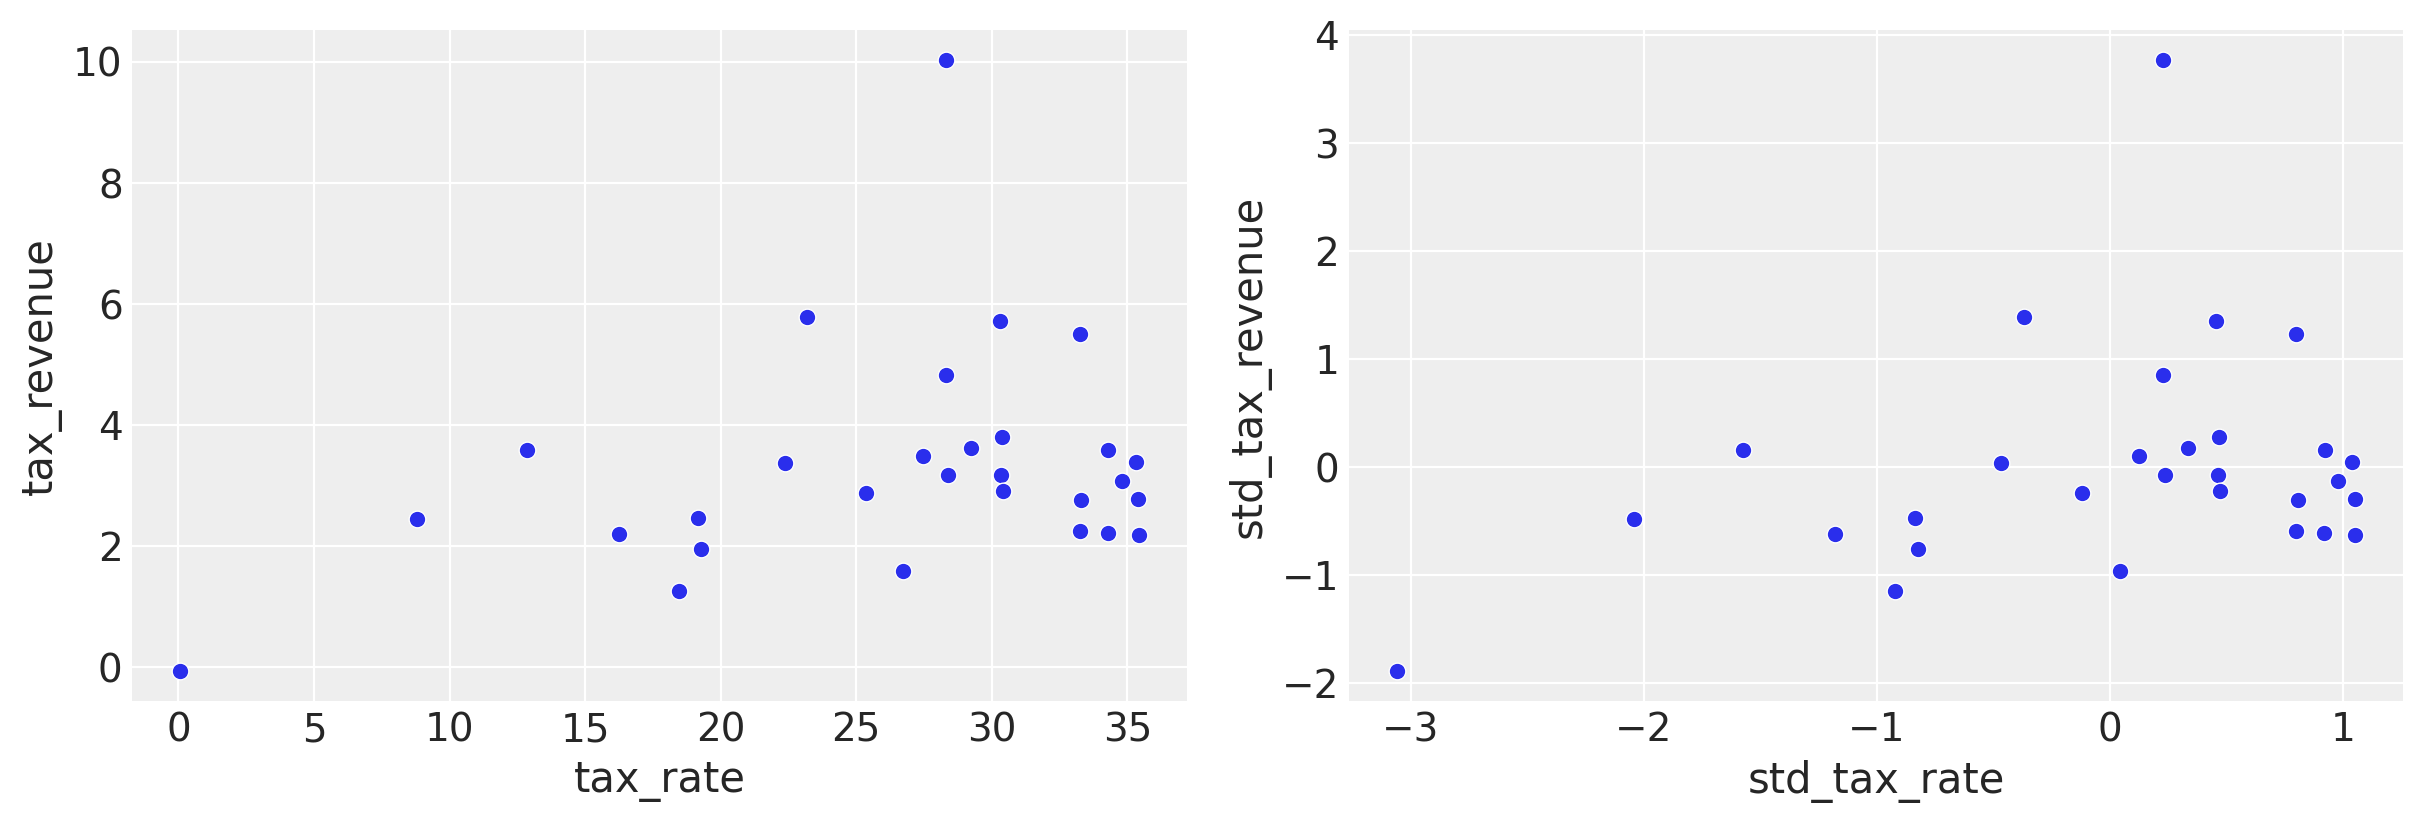

<IPython.core.display.Javascript object>

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(data=df_Laffer, x="tax_rate", y="tax_revenue", ax=ax1)
sns.scatterplot(data=df_Laffer, x="std_tax_rate", y="std_tax_revenue", ax=ax2)

## Model 1, simple linear model

In [7]:
with pm.Model() as tax_model1:
    # Priors are variables a, b, sigma
    a = pm.Normal("a", mu=0, sd=2)
    b = pm.Lognormal("b", mu=0, sd=2)
    sigma = pm.Exponential("sigma", 1)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (df_Laffer['std_tax_rate'], which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * df_Laffer['std_tax_rate']

    # Likelihood is tax_rev variable
    # Height is dependent on deterministic and stochastic variables
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=df_Laffer['std_tax_revenue'])

    # The next lines is doing the fitting and sampling all at once.
    trace_m1 = pm.sample(1000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [8]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.185,-0.289,0.284,0.004,0.003,2627.0,1961.0,2633.0,2330.0,1.00
b,0.279,0.163,0.009,0.495,0.004,0.003,2088.0,2088.0,1813.0,1439.0,1.01
sigma,1.003,0.144,0.784,1.223,0.003,0.002,1882.0,1866.0,1904.0,1623.0,1.00


<IPython.core.display.Javascript object>

In [9]:
df_Laffer.head()

,tax_rate,tax_revenue,std_tax_rate,std_tax_revenue
0,0.07,-0.06,-3.059069,-1.885939
1,8.81,2.45,-2.042947,-0.479695
2,12.84,3.58,-1.574415,0.153394
3,16.24,2.19,-1.179128,-0.625362
4,19.18,2.46,-0.837320,-0.474093


<IPython.core.display.Javascript object>

In [11]:
# Input a range of rate values
rate_seq = np.arange(-3, 2, 0.2)

# This is generating a matrix where the predicted rev values will be kept
# Each rate value will be its own row
rev_pred = np.zeros((len(rate_seq), len(np.array(trace_m1.posterior["a"]).reshape(-1))))

# Fill out the matrix in this loop
for i, w in enumerate(rate_seq):
    rev_pred[i] = stats.norm.rvs(
        loc=np.array(trace_m1.posterior["a"]).reshape(-1)
        + np.array(trace_m1.posterior["b"]).reshape(-1) * w,
        scale=np.array(trace_m1.posterior["sigma"]).reshape(-1),
    )

<IPython.core.display.Javascript object>

Text(0, 0.5, 'std_tax_revenue')

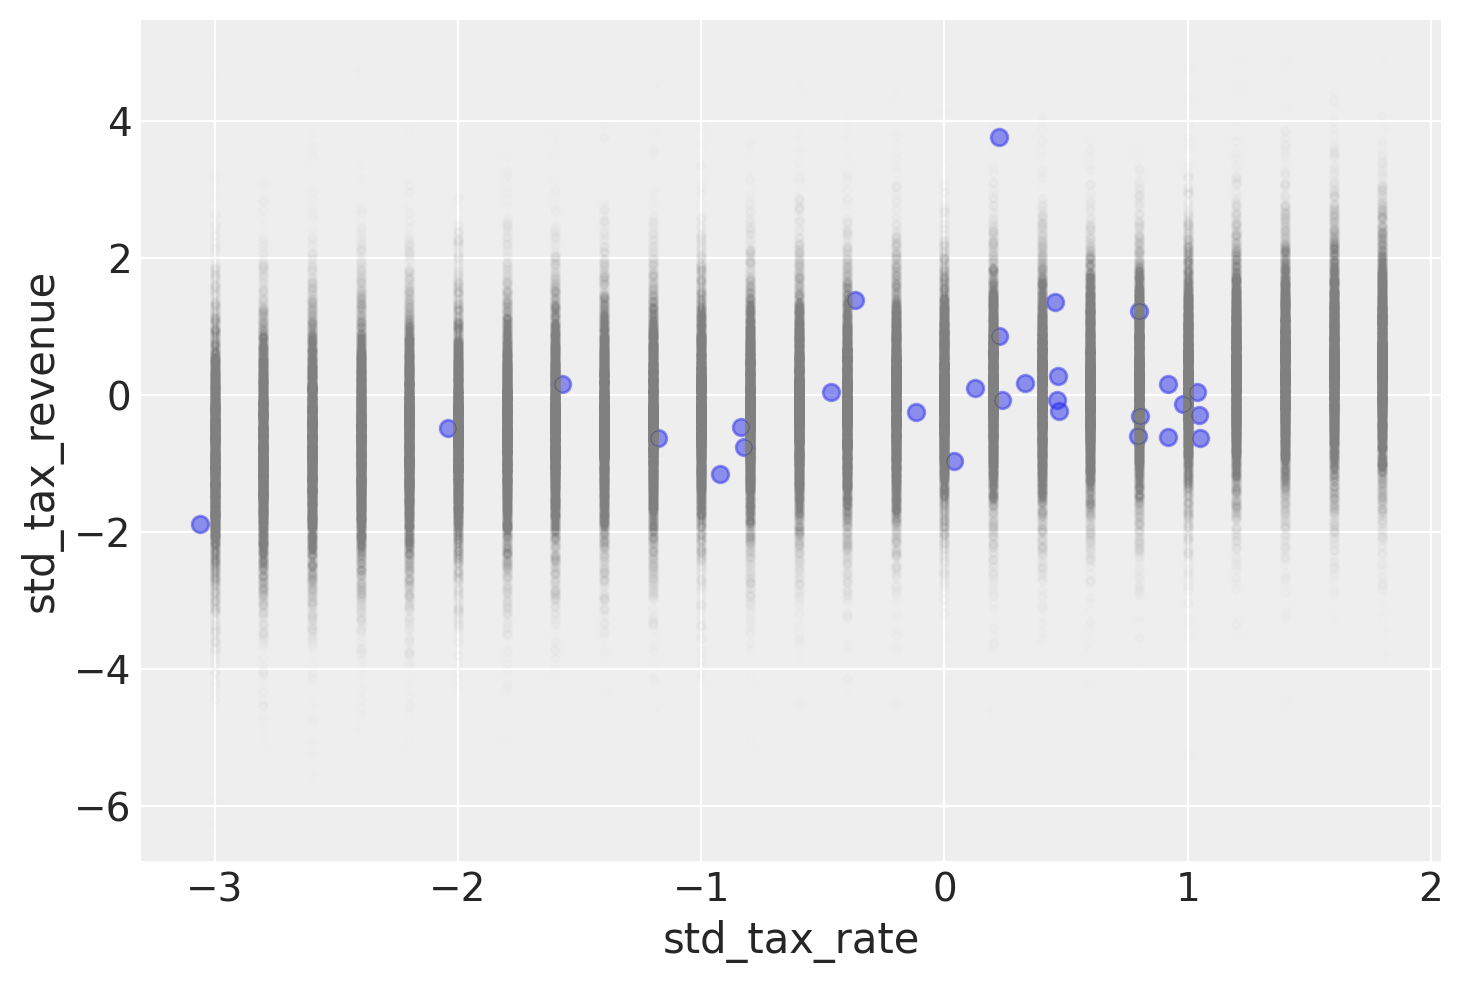

<IPython.core.display.Javascript object>

In [12]:
# Plotting the data as a scatter plot
plt.scatter(df_Laffer["std_tax_rate"], df_Laffer["std_tax_revenue"], alpha=0.5)
plt.plot(rate_seq, rev_pred, "C0.", color="gray", alpha=0.005)
plt.xlabel("std_tax_rate")
plt.ylabel("std_tax_revenue")


In [13]:
psis_m1 = az.loo(trace_m1, pointwise=True, scale="deviance")
psis_m1

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 29 log-likelihood matrix

             Estimate       SE
deviance_loo    88.67    18.98
p_loo            5.26        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       28   96.6%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    3.4%
   (1, Inf)   (very bad)    0    0.0%

<IPython.core.display.Javascript object>

In [19]:
# See which value is very high
pd.Series(psis_m1.pareto_k).sort_values(ascending=False)

11    0.868191
0     0.341524
27    0.215953
28    0.206467
26    0.167671
7     0.161552
18    0.157560
13    0.157126
25    0.148498
10    0.138757
6     0.137088
23    0.108814
24    0.108290
12    0.097002
5     0.091807
1     0.028539
3     0.016154
2     0.008010
22   -0.009197
9    -0.048352
4    -0.054054
14   -0.082264
16   -0.087802
17   -0.098386
21   -0.103068
15   -0.104845
19   -0.105298
8    -0.110077
20   -0.128165
dtype: float64

<IPython.core.display.Javascript object>

In [14]:
waic_m1 = az.waic(trace_m1, pointwise=True, scale="deviance")
waic_m1

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 29 log-likelihood matrix

              Estimate       SE
deviance_waic    88.66    18.99
p_waic            5.26        -

There has been a warning during the calculation. Please check the results.

<IPython.core.display.Javascript object>

In [22]:
pd.Series(waic_m1.waic_i).sort_values(ascending=False)

11    21.442250
10     4.347418
0      3.592417
12     3.512575
18     2.993577
7      2.894848
27     2.854516
6      2.780908
26     2.720945
25     2.625730
13     2.541308
2      2.351207
28     2.285472
5      2.201514
24     2.198747
23     2.082175
20     2.020707
3      2.014289
1      2.010020
22     1.970952
4      1.960963
19     1.928013
9      1.926082
8      1.912804
21     1.911512
17     1.905113
15     1.900586
16     1.887235
14     1.882625
dtype: float64

<IPython.core.display.Javascript object>

Text(0, 0.5, 'WAIC')

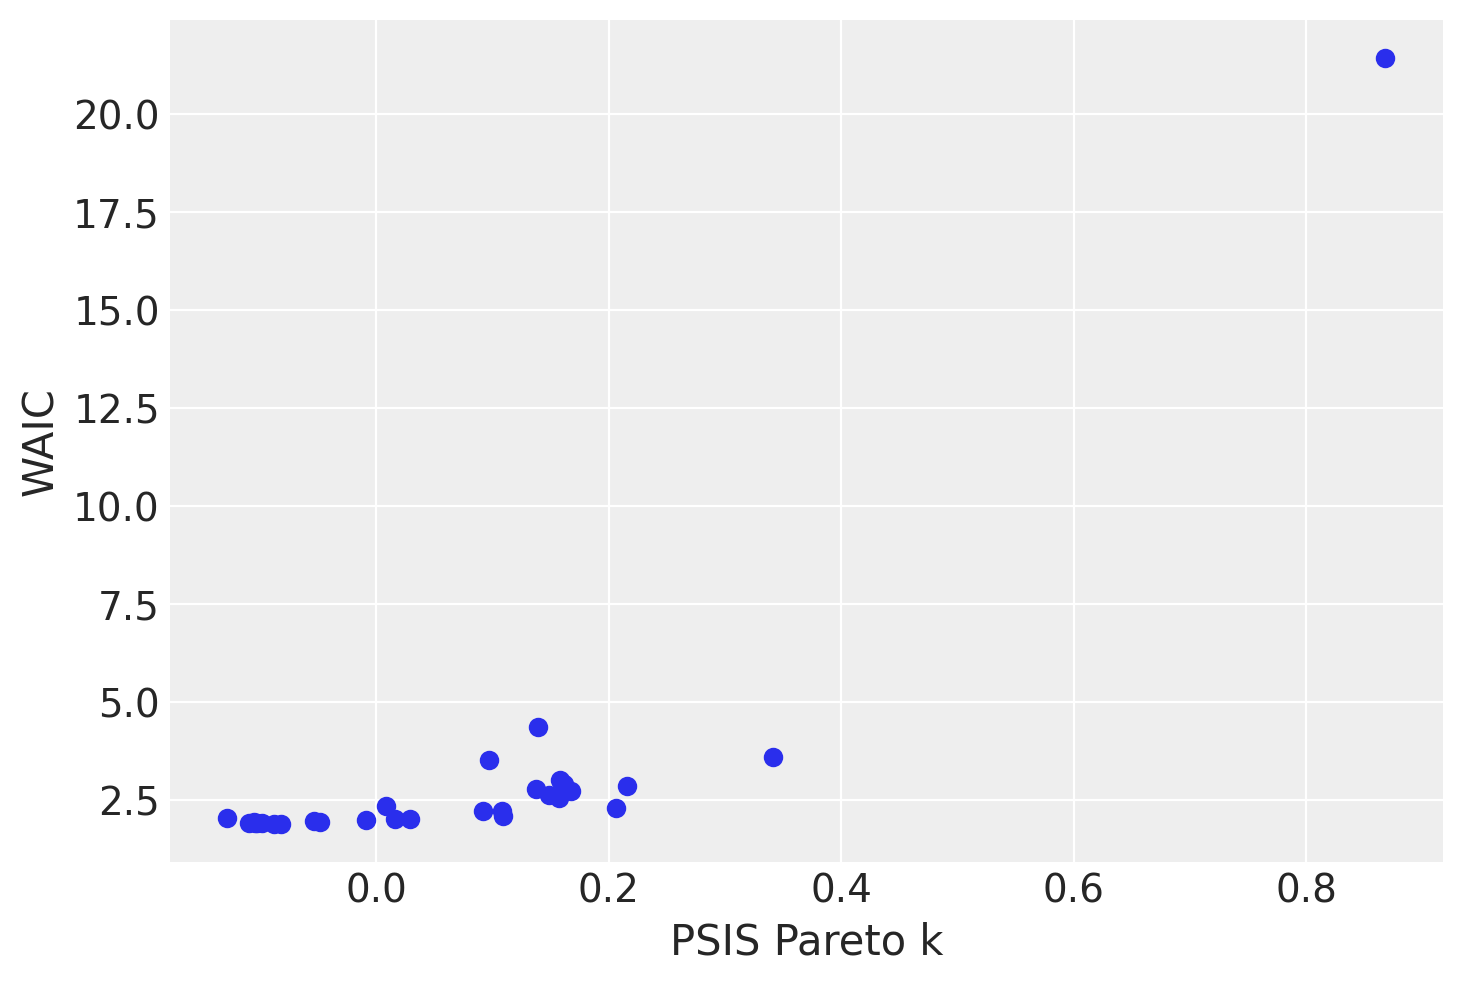

<IPython.core.display.Javascript object>

In [15]:
plt.scatter(psis_m1.pareto_k, waic_m1.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC")

## Model 3, 3rd degree

In [87]:
df_Laffer["std_tax_rate2"] = df_Laffer["std_tax_rate"] ** 2
df_Laffer["std_tax_rate3"] = df_Laffer["std_tax_rate"] ** 3


# df_Laffer["std_tax_rate2"] = standardize(df_Laffer["tax_rate"] ** 2)
# df_Laffer["std_tax_rate3"] = standardize(df_Laffer["tax_rate"] ** 3)


# df_Laffer["std_tax_rate2"] = standardize(df_Laffer["std_tax_rate"] ** 2)
# df_Laffer["std_tax_rate3"] = standardize(df_Laffer["std_tax_rate"] ** 3)

<IPython.core.display.Javascript object>

In [ ]:
with pm.Model() as tax_model3:
    # Priors are variables a, b, sigma
    a = pm.Normal("a", mu=0, sd=2)
    b = pm.Normal("b", mu=0, sd=1, shape=3)

    sigma = pm.Exponential("sigma", 1)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (df_Laffer['std_tax_rate'], which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b[0] * df_Laffer['std_tax_rate'] + b[1] * df_Laffer['std_tax_rate2'] + b[2] * df_Laffer['std_tax_rate3'] 
    # Likelihood is tax_rev variable
    # Height is dependent on deterministic and stochastic variables
    #rev = pm.Normal("rev", mu=mu, sd=sigma, observed=df_Laffer['std_tax_revenue'])
    rev = pm.Deterministic("rev", mu=mu, sd=sigma, observed=df_Laffer['std_tax_revenue'])

    # The next lines is doing the fitting and sampling all at once.
    trace_m3 = pm.sample(1000, tune=1000, return_inferencedata=True)


In [89]:
with pm.Model() as tax_model3:
    # Priors are variables a, b, sigma
    a = pm.Normal("a", mu=0, sd=2)
    b = pm.Lognormal("b", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=2)
    b3 = pm.Normal("b3", mu=0, sd=2)
    sigma = pm.Exponential("sigma", 1)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (df_Laffer['std_tax_rate'], which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * df_Laffer['std_tax_rate'] + b3 * df_Laffer['std_tax_rate3'] + b2 * df_Laffer['std_tax_rate2'] 
    # Likelihood is tax_rev variable
    # Height is dependent on deterministic and stochastic variables
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=df_Laffer['std_tax_revenue'])

    # The next lines is doing the fitting and sampling all at once.
    trace_m3 = pm.sample(1000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b3, b2, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [90]:
az.summary(trace_m3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.350,0.287,-0.090,0.796,0.008,0.005,1392.0,1392.0,1386.0,1984.0,1.0
b2,-0.548,0.356,-1.113,0.019,0.010,0.007,1166.0,1166.0,1165.0,1745.0,1.0
b3,-0.153,0.121,-0.349,0.034,0.003,0.002,1218.0,1218.0,1214.0,1857.0,1.0
b,0.350,0.179,0.074,0.593,0.004,0.003,1653.0,1653.0,1510.0,1382.0,1.0
sigma,0.979,0.143,0.767,1.201,0.004,0.003,1372.0,1372.0,1194.0,659.0,1.0


<IPython.core.display.Javascript object>

In [91]:
psis_m3 = az.loo(trace_m3, pointwise=True, scale="deviance")
psis_m3

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 29 log-likelihood matrix

             Estimate       SE
deviance_loo    88.99    16.93
p_loo            6.50        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   93.1%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    3.4%
   (1, Inf)   (very bad)    1    3.4%

<IPython.core.display.Javascript object>

In [92]:
waic_m3 = az.waic(trace_m3, pointwise=True, scale="deviance")
waic_m3

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 29 log-likelihood matrix

              Estimate       SE
deviance_waic    87.72    16.63
p_waic            5.86        -

There has been a warning during the calculation. Please check the results.

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '3rd degree')

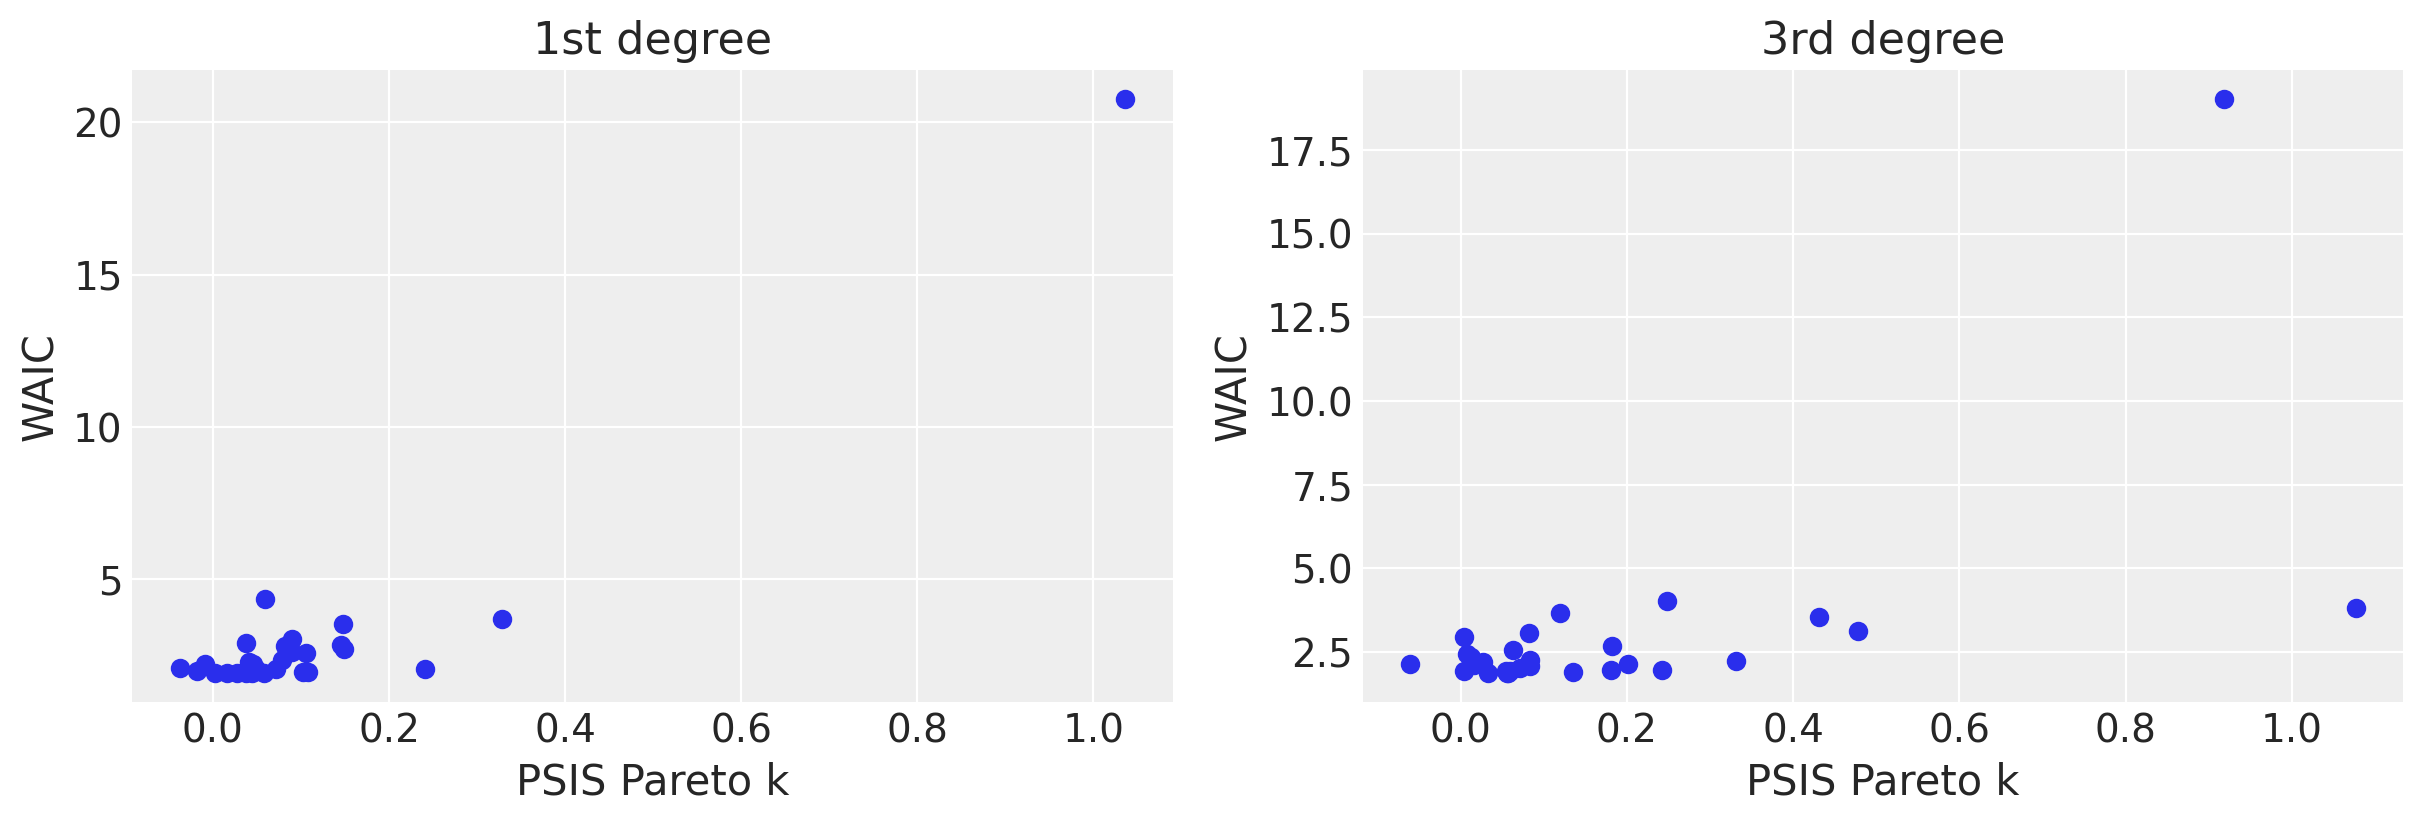

<IPython.core.display.Javascript object>

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(psis_m1.pareto_k, waic_m1.waic_i)
ax1.set_xlabel("PSIS Pareto k")
ax1.set_ylabel("WAIC")
ax1.set_title("1st degree")

ax2.scatter(psis_m3.pareto_k, waic_m3.waic_i)
ax2.set_xlabel("PSIS Pareto k")
ax2.set_ylabel("WAIC")
ax2.set_title("3rd degree")

In [99]:
az.compare({"trace1": trace_m1, "trace3": trace_m3}, scale="deviance")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
trace3,0,88.993977,6.498348,0.000000,0.506181,16.928874,0.000000,True,deviance
trace1,1,89.177013,5.464724,0.183036,0.493819,19.204792,3.565656,True,deviance


<IPython.core.display.Javascript object>

# 7H2 Laffer data, influence of outliers

In the Laffer data, there is one country with a high tax revenue that is an outlier. Use PSIS and WAIC to measure the importance of this outlier in the models you fit in the previous problem. Then use robust regression with a Student’s t distribution to revisit the curve fitting problem. How much does a curved relationship depend upon the outlier point?

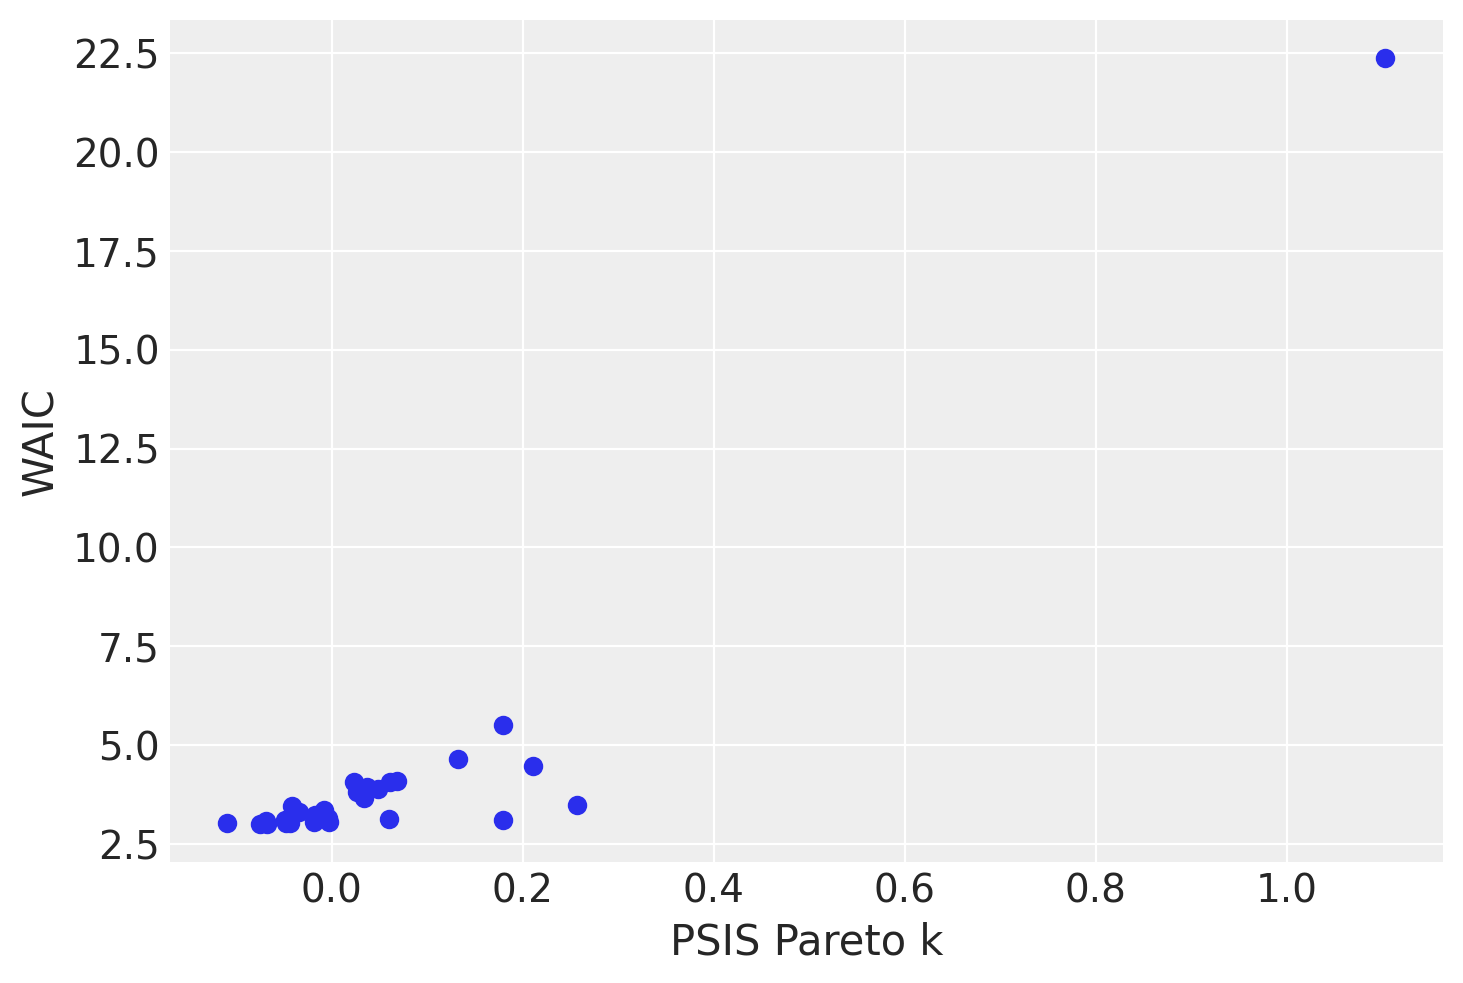

<IPython.core.display.Javascript object>

In [40]:
plt.scatter(psis_m1.pareto_k, waic_m1.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC")

In [ ]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", 2, mu, sigma, observed=d["D"])

    m_5_3t_trace = pm.sample(return_inferencedata=True)

In [51]:
with pm.Model() as tax_model_t:
    # Priors are variables a, b, sigma
    a = pm.Normal("a", mu=0, sd=2)
    b = pm.Lognormal("b", mu=0, sd=2)
    sigma = pm.Exponential("sigma", 1)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (df_Laffer['std_tax_rate'], which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * df_Laffer['std_tax_rate']

    # Likelihood is tax_rev variable
    
    ##### Chose something for nu but don't have good rationale yet ####
    rev = pm.StudentT("rev", nu=2, mu=mu, sd=sigma, observed=df_Laffer['std_tax_revenue'])

    # The next lines is doing the fitting and sampling all at once.
    trace_m_t = pm.sample(1000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [52]:
az.summary(trace_m_t)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.019,0.596,-0.901,0.950,0.028,0.020,455.0,455.0,463.0,516.0,1.00
b,0.046,0.024,0.010,0.083,0.001,0.001,477.0,465.0,477.0,604.0,1.00
sigma,0.882,0.198,0.593,1.179,0.007,0.005,877.0,877.0,883.0,1154.0,1.01


<IPython.core.display.Javascript object>

In [54]:
psis_mt = az.loo(trace_m_t, pointwise=True, scale="deviance")
psis_mt

Computed from 4000 by 29 log-likelihood matrix

             Estimate       SE
deviance_loo   107.78    12.65
p_loo            3.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       29  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<IPython.core.display.Javascript object>

In [55]:
waic_mt = az.waic(trace_m_t, pointwise=True, scale="deviance")
waic_mt

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 29 log-likelihood matrix

              Estimate       SE
deviance_waic   107.81    12.65
p_waic            3.07        -

There has been a warning during the calculation. Please check the results.

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'using Student t')

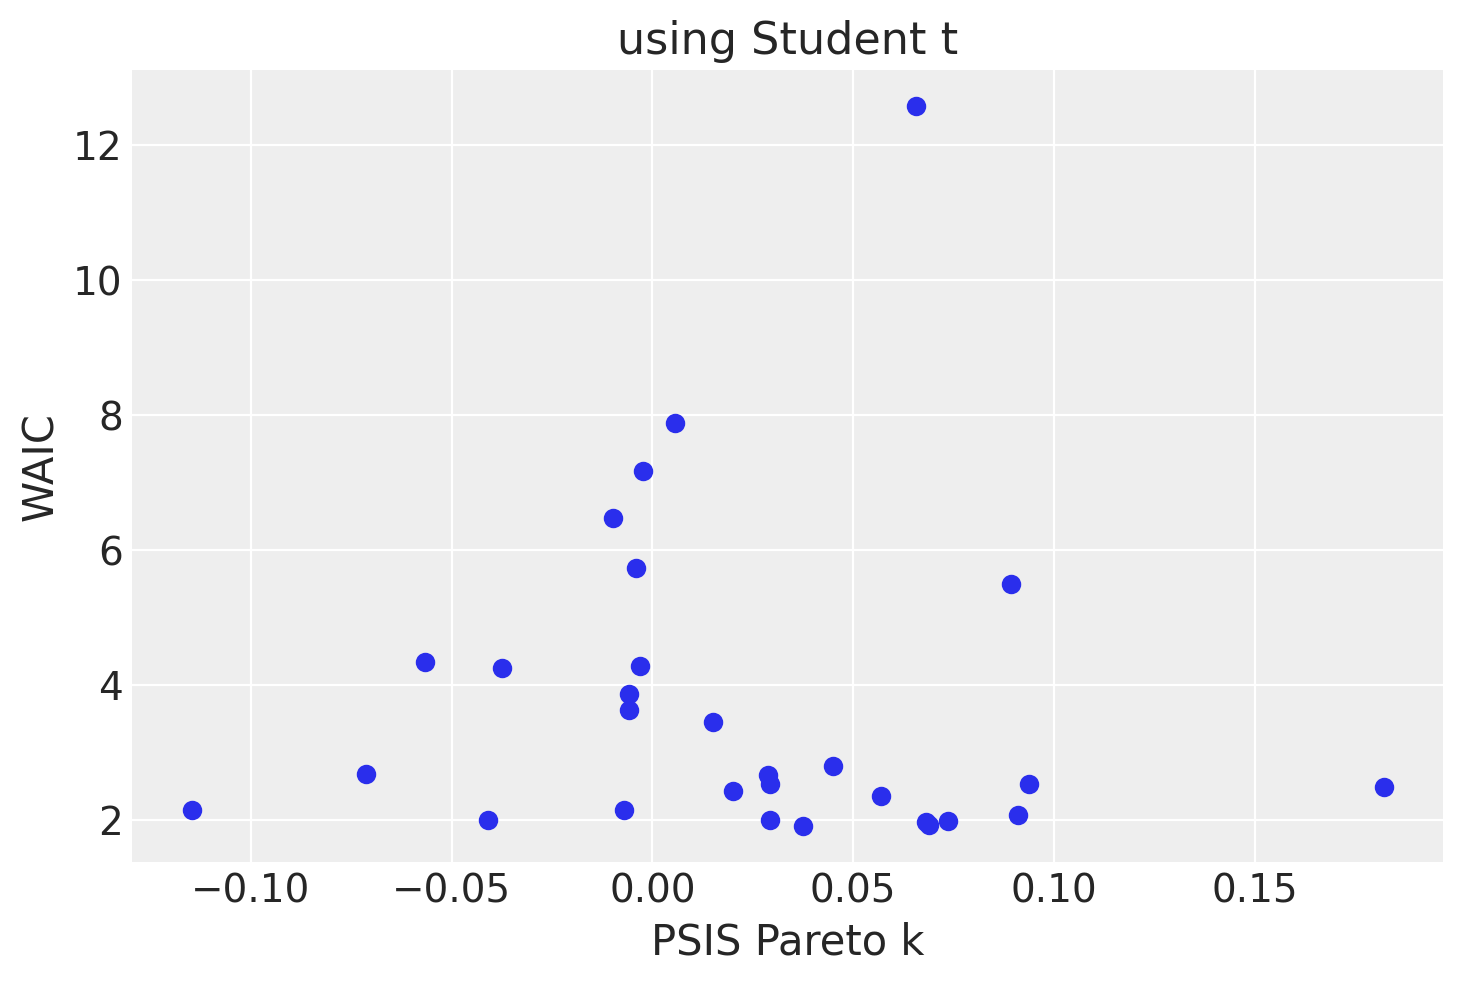

<IPython.core.display.Javascript object>

In [56]:
plt.scatter(psis_mt.pareto_k, waic_mt.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC")
plt.title("using Student t")

In [ ]:
# https://github.com/rmcelreath/rethinking/tree/master/data

Appendix: Environment and system parameters

In [4]:
%watermark -n -u -v -iv -w

Last updated: Sat May 22 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
arviz     : 0.11.1
daft      : 0.1.2
numpy     : 1.20.1
pymc3     : 3.11.0
seaborn   : 0.11.1
matplotlib: 3.3.4
json      : 2.0.9
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [34]:
A = np.random.randn(4,3)
B = np.sum(A, axis = 1, keepdims = True) 

<IPython.core.display.Javascript object>

In [37]:
A

array([[ 0.61312638,  1.42169741, -0.38234018],
       [-0.70383887, -0.6688344 ,  0.96368876],
       [-1.02965383, -1.45843225, -0.47987245],
       [-0.06031618,  0.27347656,  1.27221243]])

<IPython.core.display.Javascript object>

In [35]:
B

array([[ 1.65248361],
       [-0.4089845 ],
       [-2.96795852],
       [ 1.48537281]])

<IPython.core.display.Javascript object>

In [36]:
B.shape

(4, 1)

<IPython.core.display.Javascript object>

In [40]:
B = np.sum(A, axis = 1 , keepdims=False) 

<IPython.core.display.Javascript object>

In [41]:
B.shape

(4,)

<IPython.core.display.Javascript object>

In [42]:
a = np.random.randn(3, 3)
b = np.random.randn(3, 1)
c = a * b

<IPython.core.display.Javascript object>

In [43]:
c

array([[-1.27806192, -1.76607523,  0.67766421],
       [-1.18870508, -0.1125494 ,  0.00523687],
       [-0.243095  , -0.09872884,  0.15587082]])

<IPython.core.display.Javascript object>